### Flavia Carravieri
# <span style="color:deeppink"> NSL - ESERCITAZIONE 7 </span>


### Esercizio 7.1
Nelle esercitazioni precedenti, il calcolo del potenziale era troncato ad un fissato $r_{c}$. In questo esercizio si sono aggiunte le correzioni necessarie a compensare il mancato lungo raggio del potenziale, nel calcolo del'energia potenziale e della pressione. Per il potenziale di Lennard-Jones esse sono:

- $\frac{<V_{LJ}>_{tail}}{N}=\frac{8\pi \rho_{LJ} \epsilon}{9r^{9}_{c}}- \frac{8 \pi \rho_{LJ} \epsilon}{9r^{9}_{c}} $
- $\frac{<w_{LJ}>_{tail}}{3N\epsilon}=32\pi \rho_{LJ}[\frac{1}{9r_c^9}-\frac{1}{6r_c^3}]$


### Exercise 07.2
In questo esercizio si vuole valutare l'autocorrelazione tra i valori di $U/N$ dati in modo da implementare in modo efficiente il data blocking.

Per svolgere la simulazione nelle condizioni di 
- $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, per MD $dt^\star=0.001$)
si è prima fatto equilibrare il sistema, partendo da una struttura cristallina a $T^{\star}=2$. Successivamente, impostando $5 \times 10^{5}$ blocchi da un passo ciascuno, si sono ottenuti i valori istantanei di energia interna per particella. Per la simulazione Monte Carlo, si voleva avere un'accettanza del $50%$, pertanto, dopo alcuni tentativi, si è impostato $dt^{\star}= 0.101$

L'autocorrelazione indica per quanto tempo il sistema conserva memoria di sè stesso e quindi quanto un dato dipenda da quelli che lo precedono. Usando il data blocking si è sempre supposto che le medie di ogni blocco fossere scorrelate tra loro, come se fossero misurazioni indipendenti, in modo che si potesse usare la loro media e la deviazione standard della media come risultato finale. In realtà questo non è scontato e studiare l'autocorrelazione tra i dati ci porta a capire quanto devono essere grandi i blocchi affinchè ciò che si è supposto fin'ora sia effettivamente vero. Dai grafici si osserva che sia sia per la Dinamica Molecolare che per Monte Carlo, dopo qualche centinaio di passi l'autocorrelazione arriva a zero. Pertanto, usando blocchi con un numero di passi dell'ordine di $10^3$, si può essere certi di ottenere misure indipendenti. 

Tempo di autocorrelazione MD: τ ≈ 80.1 passi
Tempo di autocorrelazione MC: τ ≈ 33.6 passi


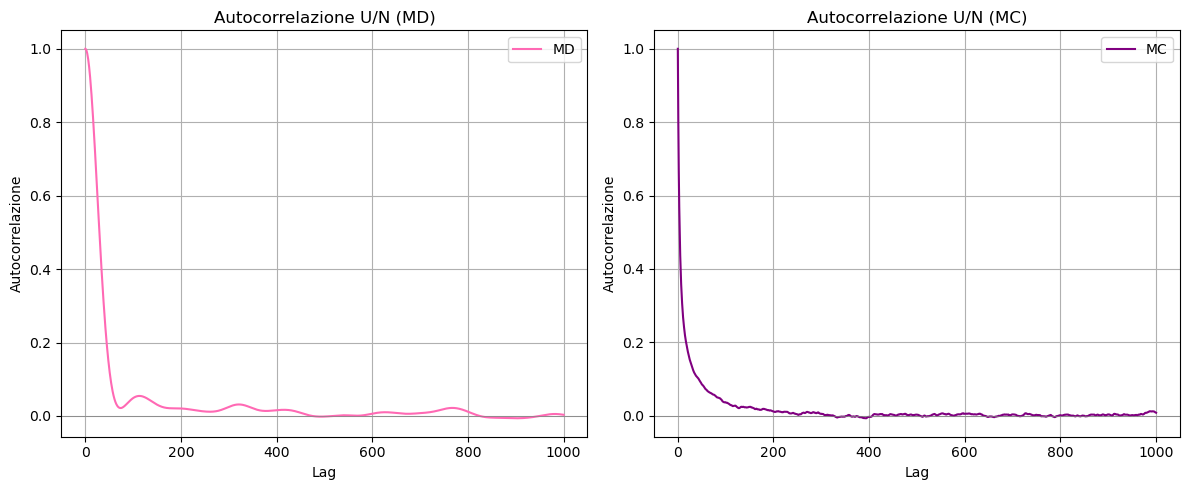

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf #acf funzione che mi calcola autocorrelazione di una serie temporale


#funzione per il tempo di autocorrelazione
def integrated_autocorrelation_time(ac): 
    try:
        zero_crossing = np.where(ac < 0)[0][0] #si segna il tempo in cui autocorrelazione (ac) diventa negativa
    except IndexError:
        zero_crossing = len(ac)
    return 1 + 2 * np.sum(ac[1:zero_crossing])

#carico i dati
#path_md = "SIMULAZIONI/SIMULAZIONI_MD_7.2/OUTPUT/potential_energy.dat"
#path_mc = "esercizio7/OUTPUT/potential_energy.dat"

#divido i dati per numero di particelle
data_md = np.loadtxt('simulazioni_eseguite_7.2/pe_MD.dat') 
data_mc = np.loadtxt('simulazioni_eseguite_7.2/pe_MC.dat') 

un_md = data_md [: , 1]
un_mc = data_mc [: , 1]

#calcolo autocorrelazione
lags = 1000  # numero massimo di lag
acf_md = acf(un_md, nlags=lags, fft=True) #fft=True mi velocizza il conto
acf_mc = acf(un_mc, nlags=lags, fft=True)

#stima del tempo di autocorrelazione
tau_md = integrated_autocorrelation_time(acf_md)
tau_mc = integrated_autocorrelation_time(acf_mc)

#stampo
print(f"Tempo di autocorrelazione MD: τ ≈ {tau_md:.1f} passi")
print(f"Tempo di autocorrelazione MC: τ ≈ {tau_mc:.1f} passi")

#plotto
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acf_md, label="MD", color='hotpink')
plt.title("Autocorrelazione U/N (MD)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.grid(True)
plt.axhline(0, color='gray', lw=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acf_mc, label="MC", color='purple')
plt.title("Autocorrelazione U/N (MC)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelazione")
plt.grid(True)
plt.axhline(0, color='gray', lw=0.5)
plt.legend()

plt.tight_layout()
plt.show()

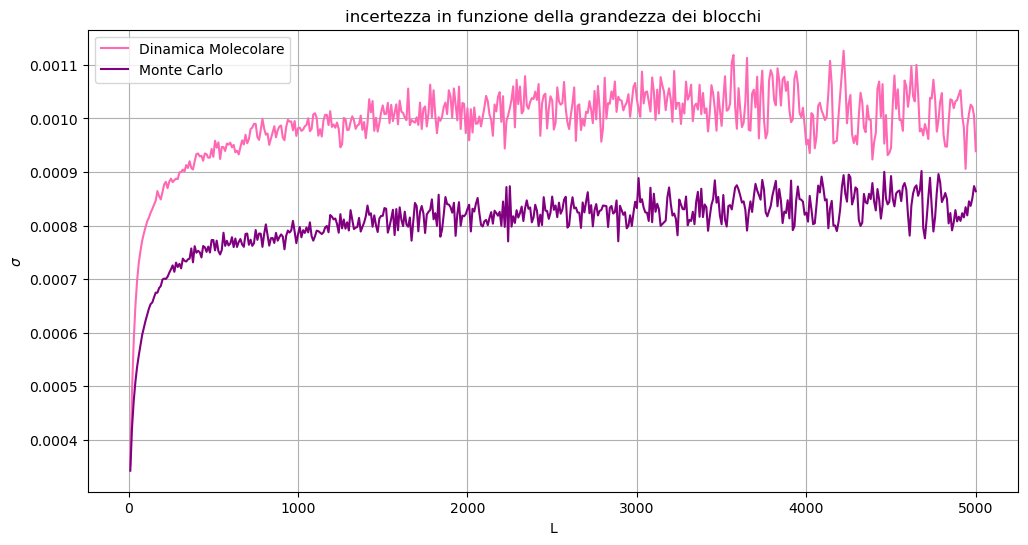

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def data_blocking(L, data):
    n_blocks=len(data)//L
    if n_blocks%len(data)!=0:
        correct_size = n_blocks * L
        data_trimmed = data[:correct_size]
        data = data_trimmed.reshape(n_blocks, L)
    data=data.reshape(n_blocks, L)
    mean=data.mean(axis=1)
    dev_std=np.sqrt(np.var(mean, ddof=1)/n_blocks)

    return dev_std
    

#leggo i dati dai file
pe_MD=np.loadtxt('simulazioni_eseguite_7.2/pe_MD.dat', usecols=(1), unpack=True)
step, pe_MC=np.loadtxt('simulazioni_eseguite_7.2/pe_MC.dat', usecols=(0,1), unpack=True)

#media a blocchi per diverse lunghezze di blocco 
L_min=10
L_max=5000
L_step=10
L_tot=np.arange(L_min, L_max+1, L_step)
err_MD=[]
err_MC=[]
x=[]

for L  in L_tot:
    if(len(step)//L < 2):
        continue
    err_MD.append(data_blocking(L, pe_MD))
    err_MC.append(data_blocking(L, pe_MC))
    x.append(L)
plt.figure(figsize=(12, 6))
plt.plot(x, err_MD, color='hotpink', label='Dinamica Molecolare')
plt.plot(x, err_MC, color='purple', label='Monte Carlo')
plt.title('incertezza in funzione della grandezza dei blocchi')
plt.xlabel('L')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.grid()
plt.show()

Questo secondo grafico, invece, mostra l'andamento dell'errore statistico in funzione della grandezza dei blocchi. Dopo un'iniziale crescita - inevitabile dato il risultato sopra ottenuto - l'errore tende a stabilizzarsi e rimanere pressocchè costante. Questo significa che non è utile usare blocchi troppo grandi, poichè l'errore non diminuisce e, anzi, aumenta il costo computazionale. 

### Esercizio 7.3
L'ultimo tassello mancante al codice per lo studio dei sistemi è il calcolo della funzione di distribuzione radiale $g(r)$. Per un istema di N particella, essa è definita come $$g_{N}^{(n)}(\vec{r_{1}}, ..., \vec{r_{N}})=\frac{\rho_{N}^{(n)}(\vec{r_{1}}, ..., \vec{r_{N}})}{\prod_{i=1}^{N} \rho_{N} ^{(1)} (\vec{r_{i}})}$$
dove $r_{i}$ è la posizione dell'i-esima particella e $\rho_{N}^{(n)}(\vec{r_{1}}, ..., \vec{r_{N}})$ è la densità di n particelle.

In un fluido omogeneo $g$ dipende solo dalle distanze reciproche tra la particelle e si può dimostrare che $$g(r)=\frac{1}{\rho N\Delta V(r)}<\sum \sum^{N}_{i\neq j =1}\delta [|\vec{r}|-|(\vec{r_{i}}-\vec{r_{j}})|]>$$ con $\Delta V(r)=\frac{4 \pi}{3}[(r+dr)^{3}-r^{3}]$. 

Nel codice si va quindi a riempire un istogramma incrementando un bin $r$ ogni volta che si trovano due particelle con una distanza tra $r$ e $r+dr$; si normalizza poi dividendo per $\rho N \Delta V(r)$.

### Esercizio 7.4
Si è infine eseguita la simulazione, sia Monte Carlo che di Dinamica Molecolare, con il modello di Lennard-Jones, per un sistema di $N=108$ particelle equilibrato ad ottenere le seguenti condizioni: 
- $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)

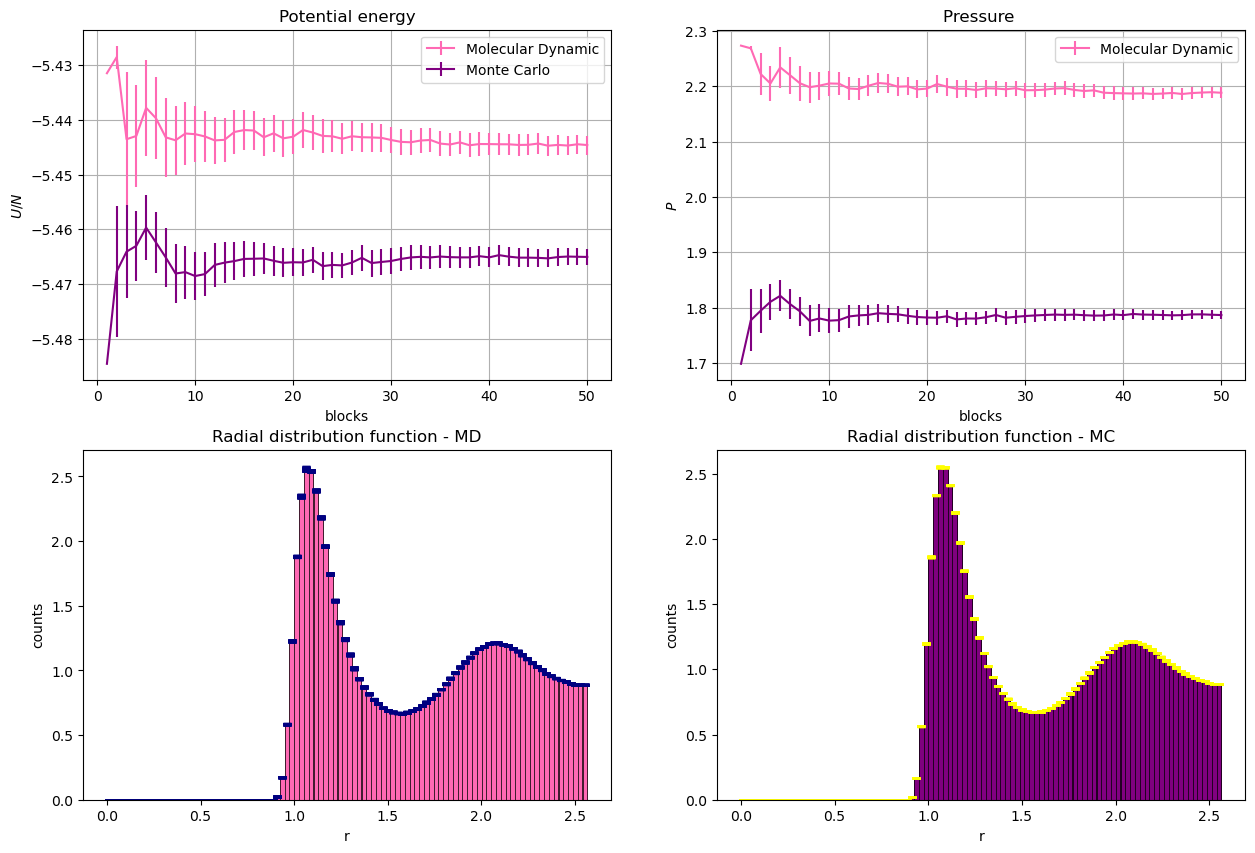

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#caricamento dati
blocks=np.loadtxt('simulazioni_eseguite_7.4/MD/potential_energy.dat', usecols=(0))
U_MD, err_U_MD=np.loadtxt('simulazioni_eseguite_7.4/MD/potential_energy.dat', usecols=(2,3), unpack=True)
P_MD, err_P_MD=np.loadtxt('simulazioni_eseguite_7.4/MD/pressure.dat', usecols=(2,3), unpack=True)
r_MD, G_MD, err_G_MD=np.loadtxt('simulazioni_eseguite_7.4/MD/gofr.dat', skiprows=1901, usecols=(0,1,2), unpack=True)

U_MC, err_U_MC=np.loadtxt('simulazioni_eseguite_7.4/MC/potential_energy.dat', usecols=(2,3), unpack=True)
blocks_MC, P_MC, err_P_MC=np.loadtxt('simulazioni_eseguite_7.4/MC/pressure.dat', usecols=(0, 2,3), unpack=True)      
r_MC, G_MC, err_G_MC=np.loadtxt('simulazioni_eseguite_7.4/MC/gofr.dat', skiprows=1901, usecols=(0,1,2), unpack=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].errorbar(blocks, U_MD, yerr=err_U_MD, color='hotpink', linesytle=None, label='Molecular Dynamic')
axs[0,0].errorbar(blocks, U_MC, yerr=err_U_MC, color='purple', linesytle=None, label='Monte Carlo')
axs[0,0].set_title('Potential energy')
axs[0,0].set_xlabel('blocks')
axs[0,0].set_ylabel('$U/N$')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].errorbar(blocks, P_MD, yerr=err_P_MD, color='hotpink', linestyle=None, label='Molecular Dynamic')
axs[0,1].set_title('Pressure ')
axs[0,1].set_xlabel('blocks')
axs[0,1].set_ylabel('$P$')
axs[0,1].legend()
axs[0,1].grid()

axs[0,1].errorbar(blocks_MC, P_MC, yerr=err_P_MC, color='purple', linestyle=None, label='Monte Carlo')


axs[1,0].bar(r_MD, G_MD, color='hotpink', alpha=0.7, width=(r_MD[-1] - r_MD[0])/100, edgecolor='black',linewidth=0.5)
axs[1,0].errorbar(r_MD, G_MD, yerr=err_G_MD, linestyle='', ecolor='navy', capsize=3)
axs[1,0].set_xlabel('r')
axs[1,0].set_ylabel('counts')
axs[1,0].set_title('Radial distribution function - MD')

axs[1,1].bar(r_MC, G_MC, color='purple', alpha=0.7, width=(r_MD[-1] - r_MD[0])/100, edgecolor='black',linewidth=0.5)
axs[1,1].errorbar(r_MC, G_MC, yerr=err_G_MC, linestyle='', ecolor='yellow' , capsize=3)
axs[1,1].set_xlabel('r')
axs[1,1].set_ylabel('counts')
axs[1,1].set_title('Radial distribution function - MC')


plt.show()


I risultati quasi identici ottenuti per la distribuzione radiale, portano a pensare che entrambi i metodi usati descrivano in modo corretto il comportamento del sistema. Le discrepanze ottenute per l'energia interna e soprattuto per la pressione, posso quindi essere ricondotte alla sensiblità del sistema e ai limiti della simulazione, eseguita su un sistema finito. 